In [1]:
import numpy as np
import polars as pl
from mpmath import sinpi, cospi
from scipy.optimize import curve_fit

In [2]:
root =  "https://gml.noaa.gov/grad/solcalc/"
stem = "NOAA_Solar_Calculations_year"

In [3]:
df = pl.read_ods(
    stem + ".ods" # local file
    # root + stem + ".ods" # url
)

Could not determine dtype for column 2, falling back to string
Could not determine dtype for column 7, falling back to string


In [4]:
def ymdhms2doe(datecol: str, timecol: str, outcol: str) -> pl.Expr:
    return (
        pl.col(datecol).dt.epoch(time_unit="s")
        / 86400
        + pl.col(timecol)
        + 719468
    ).alias(outcol)

In [5]:
def doe2coe(incol: str, outcol: str) -> pl.Expr:
    incol_expr = pl.col(incol)
    return (
        pl.when(incol_expr >= 0)
        .then(incol_expr)
        .otherwise(incol_expr - 146096)
        // 146097
    ).alias(outcol)

In [6]:
def coe2doc(doecol: str, coecol: str, outcol: str) -> pl.Expr:
    return (
        pl.col(doecol)
        - pl.col(coecol)
        * 146097
    ).alias(outcol)

In [7]:
def doc2yoc(incol: str, outcol: str) -> pl.Expr:
    incol_expr = pl.col(incol)
    return ((
        incol_expr
        - incol_expr // 1460
        + incol_expr // 36524
        - incol_expr // 146096
        ) // 365
    ).alias(outcol)

In [8]:
def yoc2yoe(yoccol: str, coecol: str, outcol: str) -> pl.Expr:
    return (
        pl.col(yoccol) + pl.col(coecol) * 400
    ).cast(pl.Int32).alias(outcol)

In [9]:
def yoc2yda(doccol: str, yoccol: str, outcol: str) -> pl.Expr:
    yoccol_expr = pl.col(yoccol)
    return (
        pl.col(doccol) - (
            yoccol_expr * 365
            + yoccol_expr // 4
            - yoccol_expr // 100
        )).alias(outcol)

In [10]:
def yda2doy(incol: str, outcol: str) -> pl.Expr:
    return pl.col(incol).floor().cast(pl.Int32).alias(outcol)

In [11]:
def yda2toy(incol: str, diy: int, outcol: str) -> pl.Expr:
    return (pl.col(incol) / diy).alias(outcol)

In [12]:
def min2cd(incol: str, outcol: str) -> pl.Expr:
    return (pl.col(incol) / 1.44).alias(outcol)

In [13]:
df = (
    df.with_columns(ymdhms2doe(
        "Date",
        "Time (hrs past local midnight)",
        "doe",
    )).with_columns(doe2coe(
        "doe", "coe"
    )).with_columns(coe2doc(
        "doe", "coe", "doc",
    )).with_columns(doc2yoc(
        "doc", "yoc",
    )).with_columns(
        yoc2yoe("yoc", "coe", "yoe"),
        yoc2yda("doc", "yoc", "yda"),
    ).with_columns(
        yda2toy("yda", 365, "toy"),
        yda2doy("yda", "doy"),
        min2cd(
            "Eq of Time (minutes)",
            "eot",
        )
    )
)

In [14]:
df.select(["yoe", "yda", "doy", "toy", "eot"]).head()

yoe,yda,doy,toy,eot
i32,f64,i32,f64,f64
2025,306.5,306,0.839726,-2.572193
2025,307.5,307,0.842466,-2.895113
2025,308.5,308,0.845205,-3.213904
2025,309.5,309,0.847945,-3.528227
2025,310.5,310,0.850685,-3.837754


In [15]:
costau = np.vectorize(lambda x: np.float64(cospi(2 * x)))

In [16]:
sintau = np.vectorize(lambda x: np.float64(sinpi(2 * x)))

In [17]:
costau([0, .25, .5, .75, 1])

array([ 1.,  0., -1.,  0.,  1.])

In [18]:
sintau([0, .25, .5, .75, 1])

array([ 0.,  1.,  0., -1.,  0.])

In [19]:
def model(toy, p0, p1, p2, p3, p4):
    return (
        p0 +
        p1 * costau(toy) +
        p2 * sintau(toy) +
        p3 * costau(2 * toy) +
        p4 * sintau(2 * toy)
    )

In [20]:
#| label: eot
popt, pcov = curve_fit(model, df["toy"], df["eot"])
dict(enumerate(popt.tolist()))

{0: 0.0011114386869002235,
 1: -4.155124400404918,
 2: -2.9710873225303756,
 3: -4.635570414590801,
 4: 5.116176940364264}

In [21]:
df = df.with_columns(pl.Series(name="fit", values=model(df["toy"], *popt)))

In [22]:
df["fit"].max()

11.409907228557664

In [23]:
df["fit"].min()

-9.81710322341188

In [24]:
plotopts = {"linewidth": 4, "legend": True, "x": "doy"}

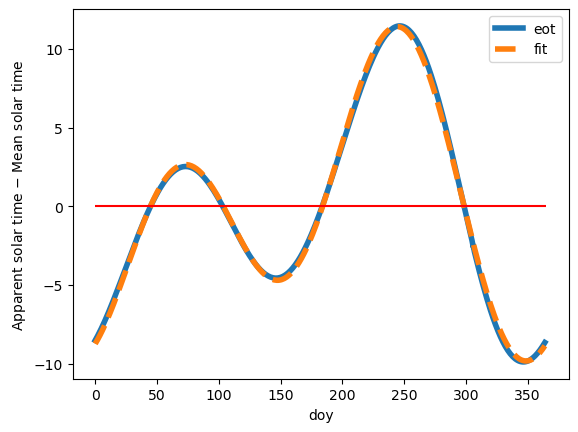

In [25]:
plotdf = df.to_pandas().sort_values("doy")
ax = plotdf.plot(
    y="eot",
    xlabel="Day of year",
    ylabel=r"Apparent solar time $-$ Mean solar time",
    **plotopts
)
plotdf.plot(
    y="fit",
    linestyle="--",
    ax=ax,
    **plotopts
).hlines(y=0, xmin=0, xmax=365, color='r', linestyle='-');

In [26]:
df = df.with_columns((pl.col("Sun Declin (deg)") / 360).alias("sda"))

In [27]:
popt, pcov = curve_fit(model, df["toy"], df["sda"])
dict(enumerate(popt.tolist()))

{0: 0.001091553079960761,
 1: -0.023117708562197206,
 2: 0.060320423699681706,
 3: 0.0006152631125526081,
 4: 0.0008981745798778195}

In [28]:
df = df.with_columns(pl.Series(name="fit", values=model(df["toy"], *popt)))

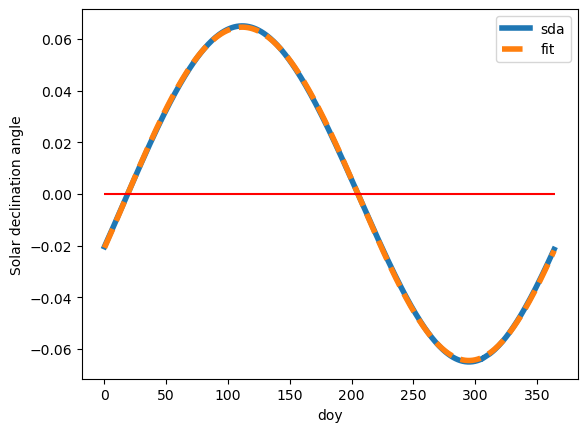

In [29]:
#| label: sdaplot
plotdf = df.to_pandas().sort_values("doy")
ax = plotdf.plot(
    y="sda",
    xlabel="Day of year",
    ylabel=r"Solar declination angle",
    **plotopts
)
plotdf.plot(
    y="fit",
    linestyle="--",
    ax=ax,
    **plotopts
).hlines(y=0, xmin=0, xmax=365, color='r', linestyle='-');

In [30]:
import math

In [31]:
def get_sunrise_sha(sdacol, lat=0.1):
    sdacol_expr = pl.col(sdacol)
    return ((((
        math.cos(.2523 * 2 * math.pi)
        - math.sin(lat * 2 * math.pi)
        * (sdacol_expr * 2 * math.pi).sin()
    ) / (
        math.cos(lat * 2 * math.pi)
        * (sdacol_expr * 2 * math.pi).cos()
    )) % 1).arccos()
            / (2 * math.pi)
            * 360
           ).alias("sha")

In [32]:
df = df.with_columns(get_sunrise_sha("sda"))

In [33]:
df.select(["doy", "sha", "HA Sunrise (deg)"])

doy,sha,HA Sunrise (deg)
i32,f64,f64
306,73.245535,73.252543
307,73.325806,73.332806
308,73.412633,73.419625
309,73.505937,73.512921
310,73.605635,73.61261
…,…,…
302,72.979995,72.987029
303,73.031716,73.038745
304,73.090262,73.097285


# Bonus examples

In [ ]:
# All in one go
df = df.with_columns(
    (pl.col("Date")
    .dt.epoch(time_unit="s")
    / 86400
    + pl.col("Time (hrs past local midnight)")
    + 719468
).alias("doe")).with_columns(
    (pl.when(pl.col("doe") >= 0)
       .then(pl.col("doe") // 146097)
       .otherwise((pl.col("doe") - 146096) // 146097)
).alias("coe")).with_columns(
    (pl.col("doe")
     - pl.col("coe")
     * 146097
).alias("doc")).with_columns(
    ((pl.col("doc")
      - pl.col("doc") // 1460
      + pl.col("doc") // 36524
      - pl.col("doc") // 146096
     ) // 365
).alias("yoc")).with_columns(
    (pl.col("yoc") + pl.col("coe") * 400
    ).cast(pl.Int32).alias("yoe"),
    (pl.col("doc") -
     (pl.col("yoc") * 365
      + pl.col("yoc") // 4
      - pl.col("yoc") // 100
     )).alias("yda"),
    (pl.col("Eq of Time (minutes)")
     / 1.44
).alias("eot")).with_columns(
    (pl.col("yda")
     / 365
    ).alias("toy")).with_columns(
    pl.col("yda")
    .floor()
    .cast(pl.Int32)
    .alias("doy")
)

In [ ]:
# simple Python function
def unix2yd(unix):
    doe = unix / 86400 + 719468
    coe = (
        doe if doe >= 0
        else doe - 146096
    ) // 146097
    doc = doe - coe * 146097
    yoc = (doc
        - doc // 1460
        + doc // 36524
        - doc // 146096
    ) // 365
    return [
        int(yoc + coe * 400),
        doc - (yoc * 365
            + yoc // 4
            - yoc // 100
    )]